In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

from tqdm import tqdm_notebook as tqdm

root = './input_data/DIP_2019_A1/'

In [2]:
def read_img(name, gray=False):
    fg = cv2.imread(name)
    fg = cv2.cvtColor(fg, cv2.COLOR_BGR2RGB)
    if gray: fg = cv2.cvtColor(fg, cv2.COLOR_RGB2GRAY)
    return fg


In [3]:
def plot(imgs, gray=False, titles=[], FigSize=(20,8), vmap=None):
    fig = plt.figure(figsize=FigSize)
    if len(imgs)>=3: num_plots = (np.ceil(len(imgs)/3.0),3)
    else: num_plots = (np.ceil(len(imgs)/3.0),len(imgs))
        
    vflag = True
    for i in range(len(imgs)):
        ax = fig.add_subplot(*num_plots, i+1)
        if not (vmap!=None and vflag):
            vflag=False
            vmap={}
            vmap['vmin']=np.min(imgs[i])
            vmap['vmax']=np.max(imgs[i])
        
        if not gray: ax.imshow(imgs[i])
        else: ax.imshow(imgs[i], cmap='gray', **vmap)
            
        ax.axis("off")            
        if i<len(titles): ax.title.set_text(titles[i])


---
<div width="100%" align="center"> <h1>Q1</h1></div>

---

## 1. Most frequent color

In [4]:
fg = cv2.imread(root+'fg.jpg')
fg = cv2.cvtColor(fg, cv2.COLOR_BGR2RGB)
bg = cv2.imread(root+'bg.jpg')
bg = cv2.cvtColor(bg, cv2.COLOR_BGR2RGB)

fg.shape

(720, 1280, 3)

In [5]:
def get_most_freq_color(img):
    I = np.array(img, dtype=np.float64)
    
    counts = np.zeros((256,256,256))
    
    ma = -1
    mac = []
    for i in tqdm(range(I.shape[0])):
        for j in range(I.shape[1]):
            r = int(I[i,j,0])
            g = int(I[i,j,1])
            b = int(I[i,j,2])
            counts[r,g,b] += 1
            
            if counts[r,g,b]>ma:
                ma = counts[r,g,b]
                mac = np.array([[r],[g],[b]])
    return mac

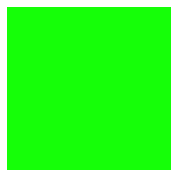

In [6]:
mac = get_most_freq_color(fg).reshape((3))
a = np.zeros((3,3,3))
for i in range(3):
    for j in range(3):
        a[i,j,:] = mac

plot([np.array(a, dtype=np.uint8)], FigSize=(3,3))

## 2. Merge Images
1. Find the most frequently occuring color in fg. This will be the background(assume).
2. Make a mask of 1 and 0. 1 in the pixels where we have the background. 0 others.  
        a. Background is determined by finding the **cosine similarity** between each pixel of the image (taken as a 
           [R,G,B] vector) and a [R,G,B] vector of the background color.
        b. If the angle between the vectors is more than 25 deg, we say that the pixel is fg, else bg.
3. Multiply the mask with the bg and inverse of the mask with fg and add to get the final img

In [7]:
def mergeImage(fg, bg, epsilon=0.8):
    fg = fg.copy()
    bg = bg.copy()
    
    mac = get_most_freq_color(fg)
    
    fg_corrected = np.array(fg,dtype=np.float64) + 0.00001
    x = np.sum(fg_corrected*mac.reshape(1,1,3), axis=2)
    x = x / np.sqrt(np.sum(fg_corrected*fg_corrected, axis=2))
    x = x / np.sqrt(np.sum(mac.reshape(1,1,3)*mac.reshape(1,1,3), axis=2))
    
    t = (x > epsilon) # t is the matrix telling us which squares to remove from fg(if true, then remove)
    t = t.reshape((t.shape[0], t.shape[1], 1))
    
    fg = np.array(~t, dtype=np.uint8)*fg + np.array(t, dtype=np.uint8)*bg
    t = t.reshape((720,1280))
    
    a = np.zeros((3,3,3))
    for i in range(3):
        for j in range(3):
            a[i,j,:] = mac.reshape(3)
    a = np.array(a, dtype=np.uint8)
    plot([t, a], gray=True, FigSize=(8,8), titles=["FG MASK", "BG COLOR"])
    return fg

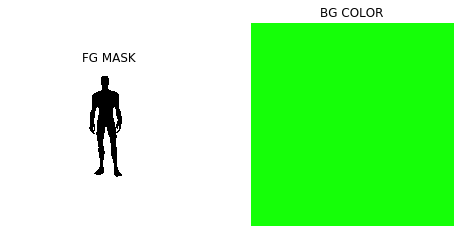

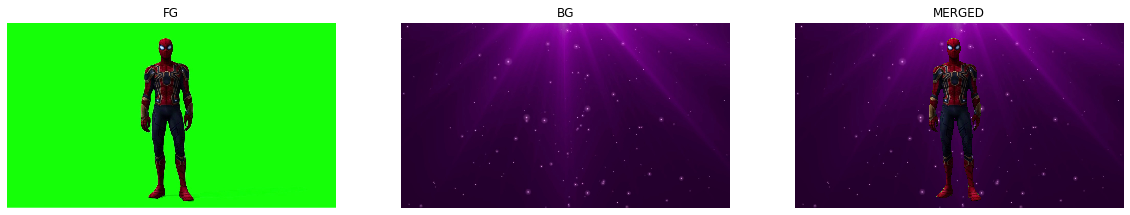

In [8]:
op = mergeImage(fg,bg,epsilon=0.90)

plot([fg,bg,op], FigSize=(20,20), titles=["FG", "BG", "MERGED"])

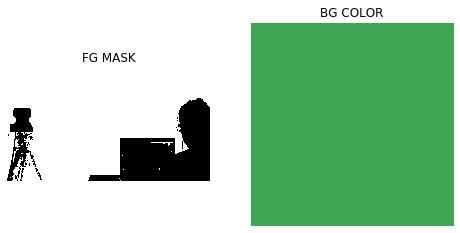

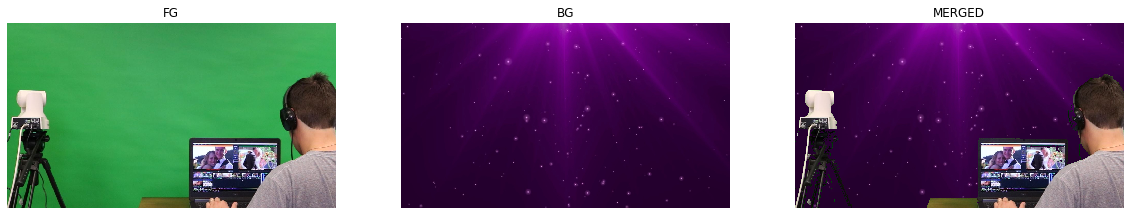

In [9]:
fg1 = read_img(root+'../inputs/fg_complex.jpg')
fg1 = fg1[100:820,100:1380,:]
op = mergeImage(fg1,bg,epsilon=0.95)
plot([fg1,bg,op], FigSize=(20,20),  titles=["FG", "BG", "MERGED"])

---
<div width="100%" align="center"> <h1>Q2</h1></div>

---

## 1. Line Contrast Stretching

In [10]:
cam = read_img(root+'cameraman.png', gray=True)
eye = read_img(root+'eye.png', gray=True)
fg = read_img(root+'fg.jpg', gray=True)

In [11]:
def getColorbar(img, k):
    h = []
    for i in range(256):
        h.append(np.sum(np.array(img == i, dtype=np.float64)))
    idxs = np.argsort(np.array(h))[::-1]
    idxs = idxs[:k, np.newaxis]
    
    img = img.copy()
    
    sz = int(np.ceil(img.shape[0]/k))
    width = int(img.shape[1]/25)
    a = [idxs[int(i/sz),0] for i in range(img.shape[0]) for j in range(width)]
    a = np.array(a)[:, np.newaxis].reshape((-1,width))
    
    a[::sz,:] = 255
    a[1::sz,:] = 255
    z = np.zeros((a.shape[0], width))+255
    img = np.hstack((img, z, a))
    return img

In [12]:
def linContrastStretching(img, a, b, k=10, Plot=True):
    '''
    min maps to a
    max maps to b
    basically a line between (min,a) and (max,b)
    s = (b-a)/(max-min) (r-min) + a
    '''
    
    img = np.array(img, dtype=np.float64)
    m = np.min(img)
    M = np.max(img)
    
    img_dash = np.round((b-a)*(img-m)/(M-m) + a, decimals=0)
    
    if Plot:
        img_c = getColorbar(img,k)
        img_dash_c = getColorbar(img_dash, k)
        
        a = ["{}-{}".format(np.min(img), np.max(img)), \
                            "{}-{}".format(np.min(img_dash), np.max(img_dash))]
        plot([img_c, img_dash_c], gray=True, vmap={'vmin':0, 'vmax':255}, titles=a)
    
    return img_dash

In [13]:
dark = linContrastStretching(eye, 0, 100, Plot=False)
light = linContrastStretching(eye, 50, 255, Plot=False)

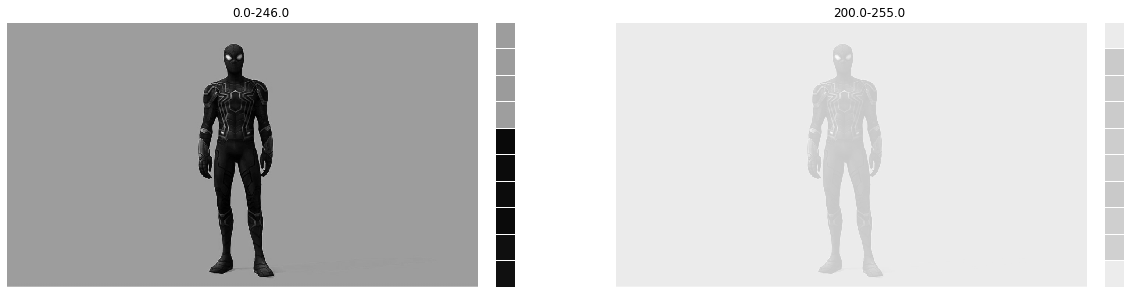

In [14]:
a = linContrastStretching(fg, 200,255)

---
Here,in the left image, the background is mostly composed of a few close shades of grey. These shades are more numerous as well, therefore, the upper part of the colorbar is madeup of the background color (**most frequent**). 

Of we look at the right image, the background has mostly mapped to one color(since we can expect many colors to map to the same color in contrast stretching), hence only 1 background color is on the top, all other are foreground colors.

---

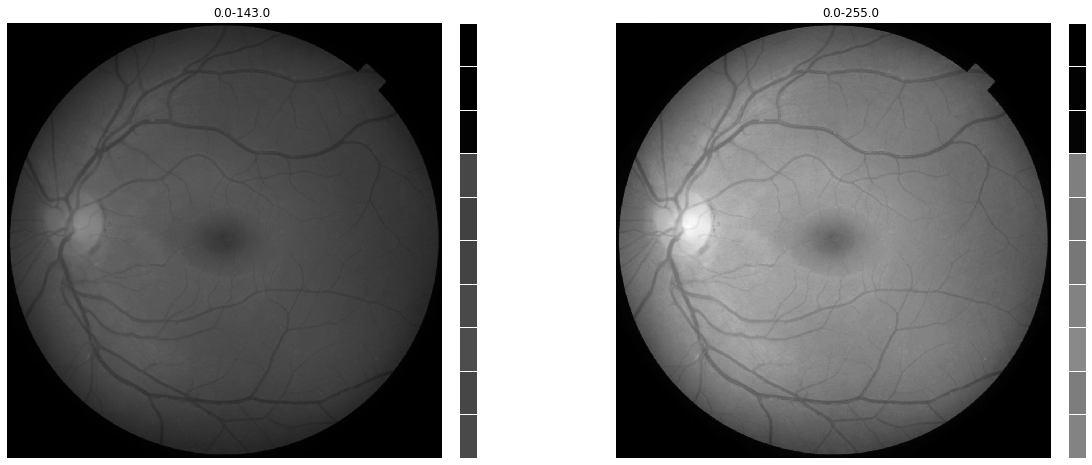

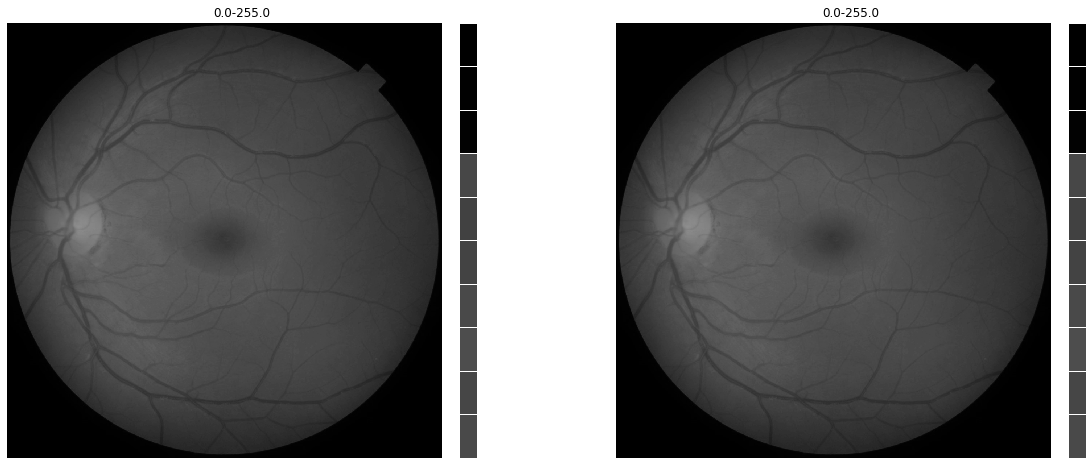

In [15]:
a = linContrastStretching(eye, 0,255)
eye2 = eye.copy()
eye2[0,0] = 255
eye2[1,1] = 0

a = linContrastStretching(eye2, 0,255)

---
#### Left img is orginal, right img is contrast stretched.
The effect is less apparent in the bottom 2 images. The only difference in the bottom left img and the top left img is the fact that I have hardcoded two pixels.
```python
eye2 = eye.copy()
eye2[0,0] = 255
eye2[1,1] = 0
```

In the top case, contrasst stretching maps 0->0 and 143->255, but in the bottom case, even though there is only 1 pixel having value 255, contrast stretching will map 0->0 and 255->255. Because of this there is almost no effect in the bootom case.

---
<div width="100%" align="center"> <h1>Q3</h1></div>

---

## 1.

In [16]:
img = read_img(root+'quantize.jpg')

In [17]:
def BitQuantizeImage(im, k, Plot=True):
    im = np.array(im, dtype=np.float64)
    im_dash = np.floor(im/np.power(2,8-k))*np.power(2,8-k)
    im_dash = np.array(im_dash, dtype=np.uint8)
    im = np.uint8(im)
    
    if Plot:
        plot([im, im_dash], FigSize=(10,10), titles=["original", "{} bit quantised".format(k)])

    return im_dash
    

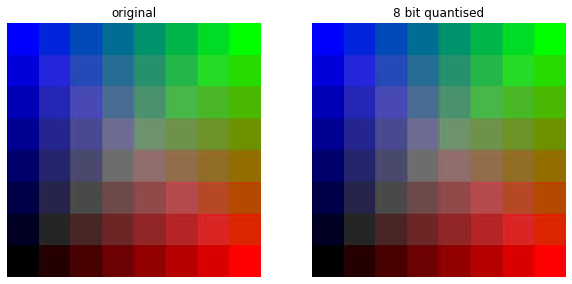

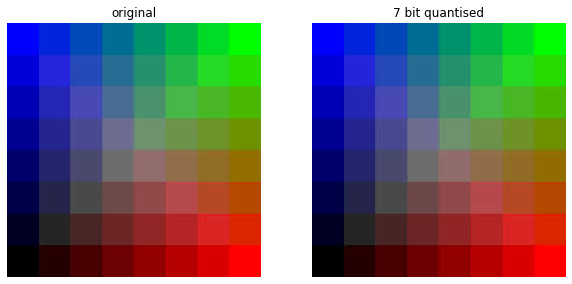

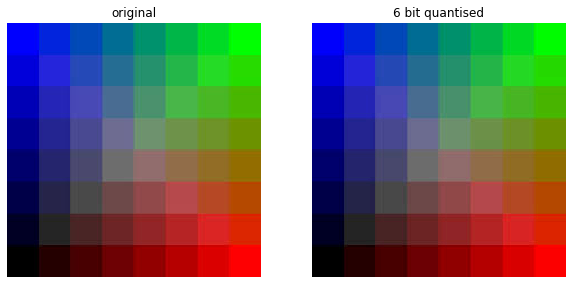

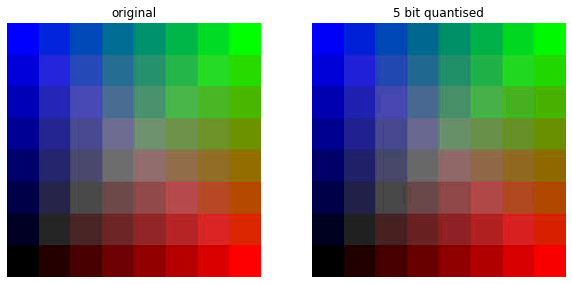

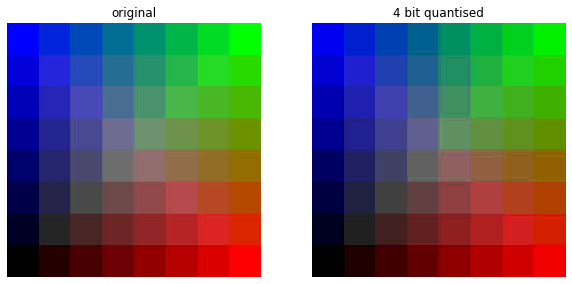

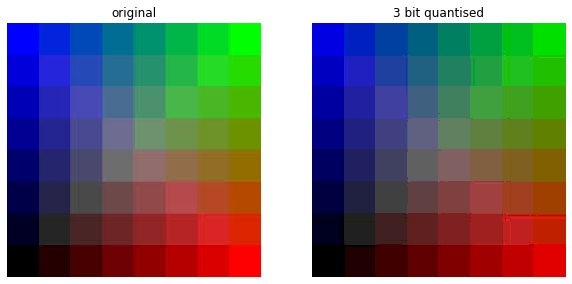

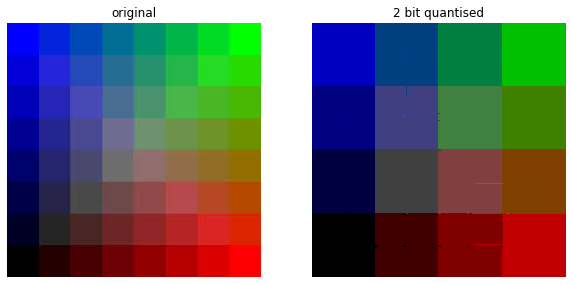

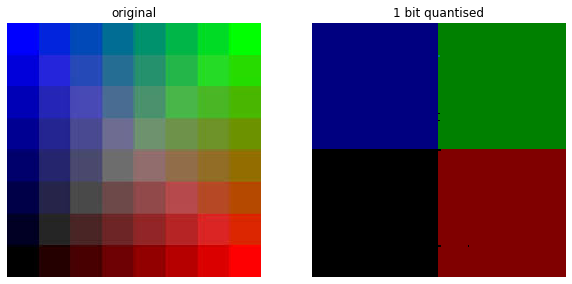

In [18]:
a = BitQuantizeImage(img, 8)
a = BitQuantizeImage(img, 7)
a = BitQuantizeImage(img, 6)
a = BitQuantizeImage(img, 5)
a = BitQuantizeImage(img, 4)
a = BitQuantizeImage(img, 3)
a = BitQuantizeImage(img, 2)
a = BitQuantizeImage(img, 1)



## 2. Bit Plane Extraction

In [19]:
img = read_img(root+'cameraman.png')
img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

In [20]:
def bitPlaneExtraction(img, Plot=True):
    imgs = [img.copy()]
    
    p = 1
    for i in range(8):
        p = np.power(2,i)
        timg = img & p
        timg = np.array(timg>0, dtype=np.uint8)
        imgs.append(timg.copy())
    
    if Plot: plot(imgs, gray=True, FigSize=(10,10), titles=["Original", *("{} bitplane".format(i+1) for i in range(8))])
    return imgs

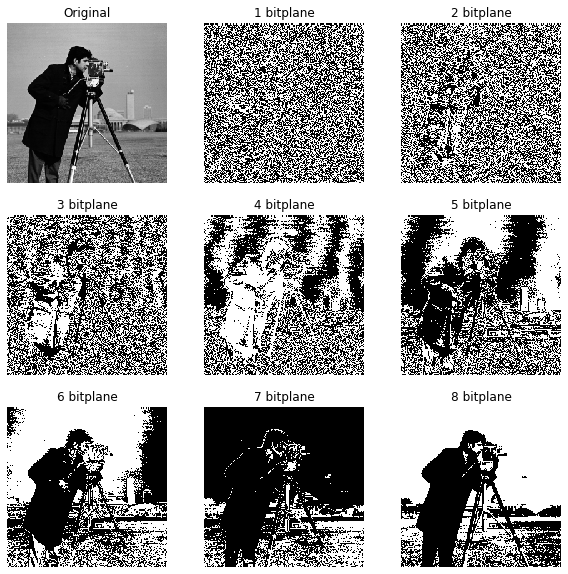

In [21]:
a = bitPlaneExtraction(img)

## 3. Lena Image Operations

In [22]:
img = read_img(root+'lena.jpg', gray=True)
img1 = read_img(root+'lena1.jpg', gray=True)
img2 = read_img(root+'lena2.jpg', gray=True)
img3 = read_img(root+'lena3.jpg', gray=True)

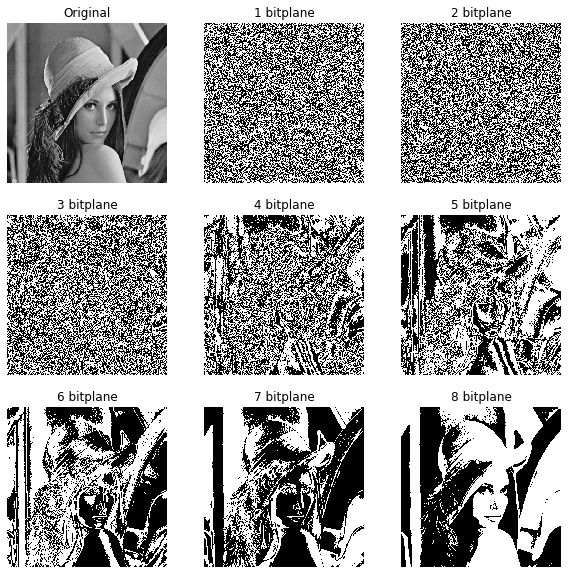

In [23]:
a = bitPlaneExtraction(img)

### a) LENA1
The operation is ***extracting the 5th bit plane***

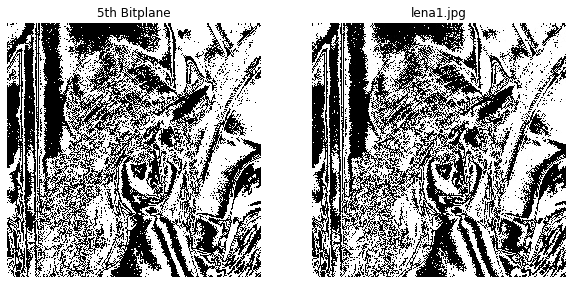

In [24]:
a = bitPlaneExtraction(img, Plot=False)
timg = a[5]
plot([timg, img1], gray=True, titles=["5th Bitplane", "lena1.jpg"], FigSize=(10,10))

### b) LENA2
The operation is ***quantisation to 2 bits***

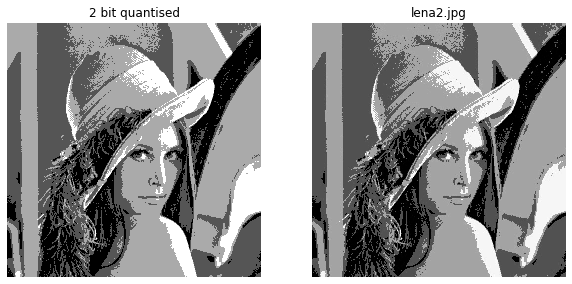

In [25]:
timg = BitQuantizeImage(img, 2, Plot=False)
plot([timg, img2], gray=True, titles=["2 bit quantised", "lena2.jpg"], FigSize=(10,10))

### c) LENA3
The operation is ***extracting the 8th bitplane***.

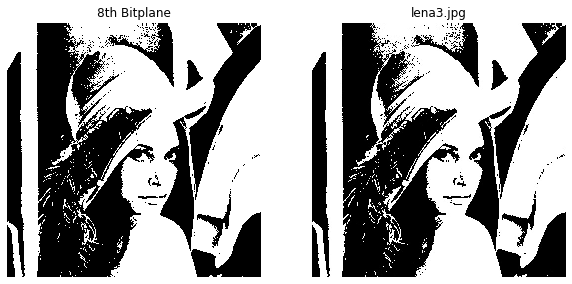

In [26]:
a = bitPlaneExtraction(img, Plot=False)
timg = a[8]
plot([timg, img3], gray=True, titles=["8th Bitplane", "lena3.jpg"], FigSize=(10,10))

---
<div width="100%" align="center"> <h1>Q4</h1></div>

---

## 1. Negative of an Image

In [27]:
img = read_img(root+"lena.jpg", gray=True)

In [28]:
def negativeImage(img, max_intensity, Plot=True):
    '''
    0 maps to L-1
    L-1 maps to 0
    L is the number of gray levels(max_intensity)
    '''
    
    img_dash = max_intensity-img.copy()
    if Plot: plot([img, img_dash], gray=True, FigSize=(10,10))
    return img_dash

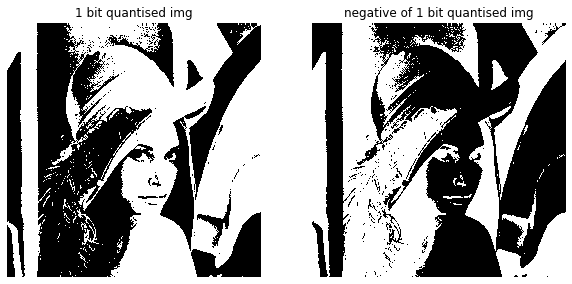

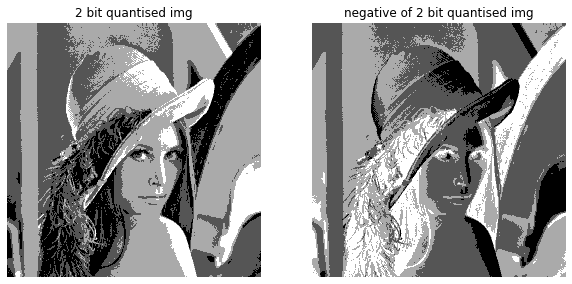

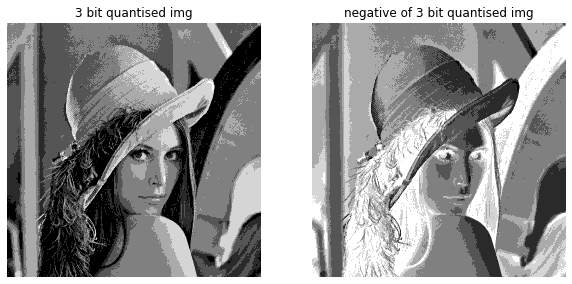

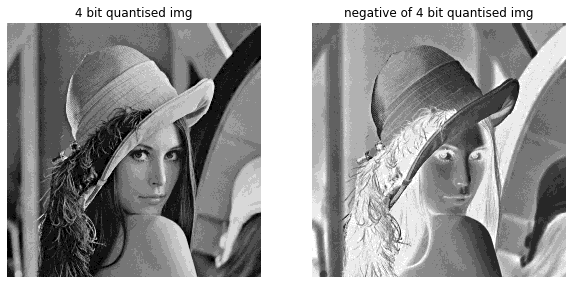

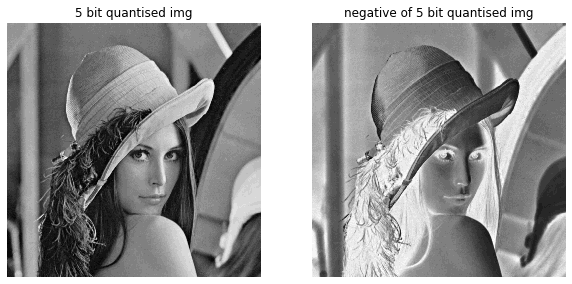

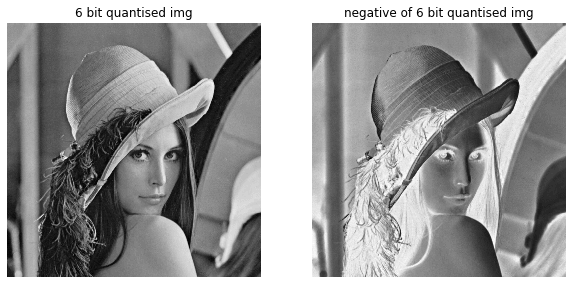

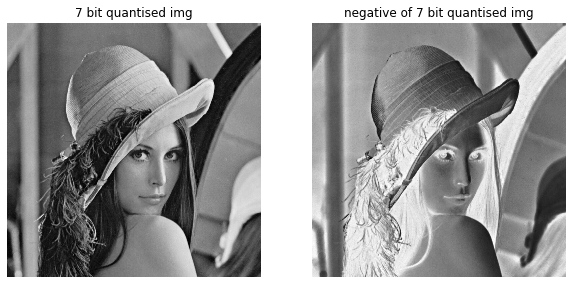

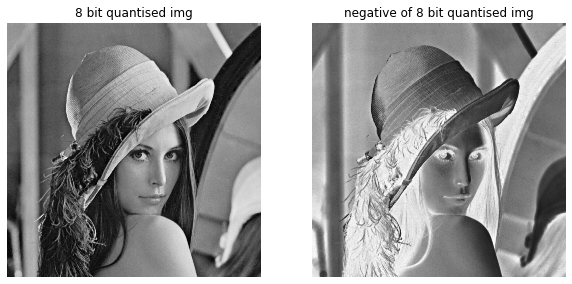

In [29]:
for i in range(1,9):
    timg = BitQuantizeImage(img, i, Plot=False)
    neg_timg = negativeImage(timg, max_intensity=np.max(timg), Plot=False)
    
    labels = ["{} bit quantised img".format(i), "negative of {} bit quantised img".format(i)]
    plot([timg, neg_timg], gray=True, titles=labels, FigSize=(10,10))

## 2. Gamma Transform

1. This is an ***Interactive Slider for Gamma (y)***
2. **Observations**  
        a. A lower value of gamma(greater than 1) causes:-
            * The lighter gray levels quickly saturate.
            * The lower grey levels also go to a more lighter shade. 
            
        b. A higher value of gamma(lower than 1) causes:-
            * All the shades become darker.
            * The darker shades are mapped to fewer values than lighter shades. ie, there is more loss of
              details in the darker grey values.

In [30]:
img = read_img(root+'gamma-corr.png', gray=True)

In [31]:
@interact(img=fixed(img), y=(0.1,2, 0.1), Plot=fixed(True))
def gammaTransform(img, y, Plot=True):
    img = np.array(img, dtype=np.float64)
    img = img/255
    timg = np.array(np.power(img, y)*255, dtype=np.uint8)
    if Plot: plot([img, timg], gray=True, titles=["original", "modified"], FigSize=(15,15))

interactive(children=(FloatSlider(value=1.0, description='y', max=2.0, min=0.1), Output()), _dom_classes=('wid…

## 3. Peicewise Linear Transform

In [32]:
img = read_img(root+"lena.jpg", gray=True)

In [33]:
def peicewiseTransform(img, coeffs, intervals, Plot=True):
    img = np.array(img, dtype=np.float64)
    timg = np.zeros((img.shape[0], img.shape[1]))
    for i in range(len(intervals)):
        a,b = intervals[i]
        k1, k2 = coeffs[i]
        
        mask = np.array(b>=img, dtype=np.float64)
        mask = mask*np.array(a<=img, dtype=np.float64)
        
        timg = timg+mask*(k1*img+k2)
        
    timg = np.array(timg, dtype=np.uint8)
    if Plot==True: 
        plot([img, timg], gray=True, 
            vmap={'vmin': 0, 'vmax': 255}, FigSize=(20,20), 
            titles=["Original", "Linear Transform"])
        
    return timg    

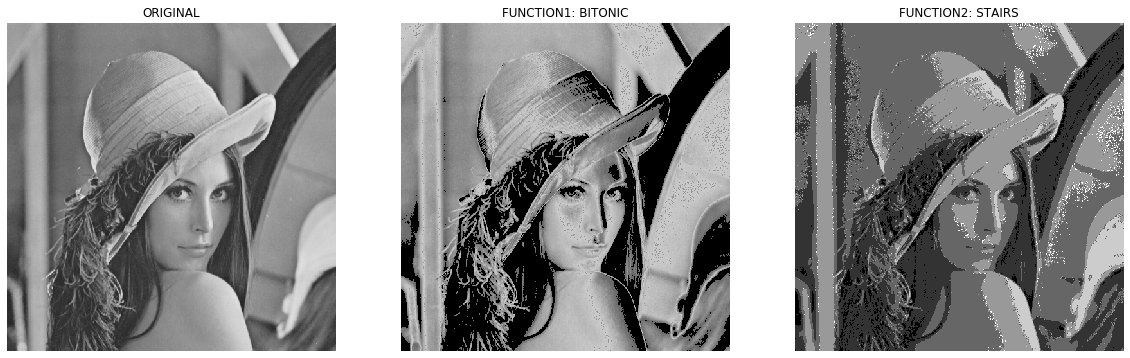

In [34]:
intervals = [(0,76), (77,153), (153, 204), (205, 255)]
coeff = [(0,0), (1.333,0), (-2, 510), (0, 0)]
a = peicewiseTransform(img, coeff, intervals, Plot=False)

intervals = [(i*25.5, (i+2)*25.5) for i in range(0,10,2)]
coeff = [(0,i*25.5) for i in range(0,10,2)]
b = peicewiseTransform(img, coeff, intervals, Plot=False)

plot([img, a,b], gray=True,
    vmap={'vmin': 0, 'vmax':255}, titles=['ORIGINAL', 'FUNCTION1: BITONIC', 'FUNCTION2: STAIRS'])

---
<div width="100%" align="center"> <h1>Q5</h1></div>

---

## 1. removing MSB

The histogram of the resulting image will be shifted to a lower continuous range. Eg if we set to 0, the most significant bit from an image in the range 0-255, we get an image whose color range is from 0-127 inclusive. The range becomes smaller but remains continuous.
**The range of colors that the image can show will reduce, but the range will be continuous.**  
**This is analogous to contrast stretching.**

## 2. removing LSB

The histogram of the ruslting image will become quantised, and dicontinous. Eg if we set to 0, the LSB of an image in the color range of 0-255, we get an image still in the range of 0-255, but every alternate color(between 0 and 255) will have 0 frequency (ie, no pixels in the image are of that color). Settin to 0, the next LSB as well(total 2 LSBs set to 0) will give us a histogram in which only every 4th color value(between 0 and 255) can be non-zero. **The range of colors that the image can show will remain the same, but the range will become discontinuous, leading to a decrease in the number of possible colors.**  
**This is analogous to quantisation.** 

---
***Hence, in both 1) and 2), the number of possible color values in the image is getting reduced.***

## 3. Transmission Rate

In [35]:
from IPython.display import Markdown as md

number_of_bytes = 512*512
number_of_bauds = number_of_bytes
number_of_bits = 10*number_of_bauds

time_over_56K_link = number_of_bits/56000

time_over_3000K_link = number_of_bits/3000000

op = """### Answers\n\n 
\n\n
```
    number_of_bytes = 512*512
    number_of_bauds = number_of_bytes
    number_of_bits = 10*number_of_bauds

    time_over_56K_link = number_of_bits/56000
    time_over_3000K_link = number_of_bits/3000000
```
**Time to send over 56K link:** {}s  \n\
**Time to send over 3000K link:** {}s  \n\n\
*Assumption: 1K baud link= 1000 bits/sec*
""".format(time_over_56K_link, time_over_3000K_link)
md(op)

### Answers

 



```
    number_of_bytes = 512*512
    number_of_bauds = number_of_bytes
    number_of_bits = 10*number_of_bauds

    time_over_56K_link = number_of_bits/56000
    time_over_3000K_link = number_of_bits/3000000
```
**Time to send over 56K link:** 46.81142857142857s  
**Time to send over 3000K link:** 0.8738133333333333s  

*Assumption: 1K baud link= 1000 bits/sec*


---
<div width="100%" align="center"> <h1>Q6</h1></div>

---

## 1. Histogram equalisation

In [36]:
img1 = read_img(root+'part1.png', gray=True)
img2 = read_img(root+'part2.png', gray=True)
img3 = read_img(root+'part3.png', gray=True)
img4 = read_img(root+'part4.png', gray=True)

img = read_img(root+'canyon.png', gray=True)

eye = read_img(root+'eye.png', gray=True)
eyeref = read_img(root+'eyeref.png', gray=True)

mount = read_img(root+'../inputs/histEqual.jpg', gray=True)

In [37]:
def histEqualization(im, Plot=True, Tr=None):
    img = np.array(im, dtype=np.float64)
    n,m = img.shape[:2]
    
    if not Tr:
        Tr = [0 for i in range(256)]
    
    s = 0
    timg = np.zeros((n,m))
    
    for i in range(256):
        mask = np.array((img==i), dtype=np.float64)
        s += np.sum(mask)/(m*n)
        Tr[i] = np.floor(255 * s)
        timg = timg + mask*Tr[i]
    
    if Plot: 
        plot([img, timg], gray=True, FigSize=(20, 10), 
            vmap={'vmin': 0, 'vmax':255}, 
            titles=['ORIGINAL', 'HISTOGRAM EQUALISED'])
        
        fig = plt.figure(figsize=(20,5))
        h1 = np.array([np.sum(np.array((img==i), dtype=np.float64)) for i in range(256)])
        h2 = np.array([np.sum(np.array((timg==i), dtype=np.float64)) for i in range(256)])
        
        ax = fig.add_subplot(121)
        ax.stem(np.linspace(0,255,256), np.log2(1+h1), use_line_collection=True)
        ax.set_ylabel("Log2 (Counts)")

        ax2 = fig.add_subplot(122)
        ax2.stem(np.linspace(0,255,256), np.log2(1+h2), use_line_collection=True) 
        ax2.set_ylabel("Log2 (Counts)")
    return timg

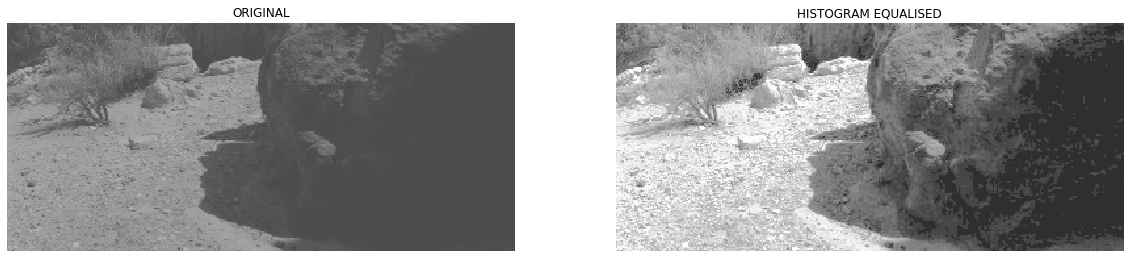

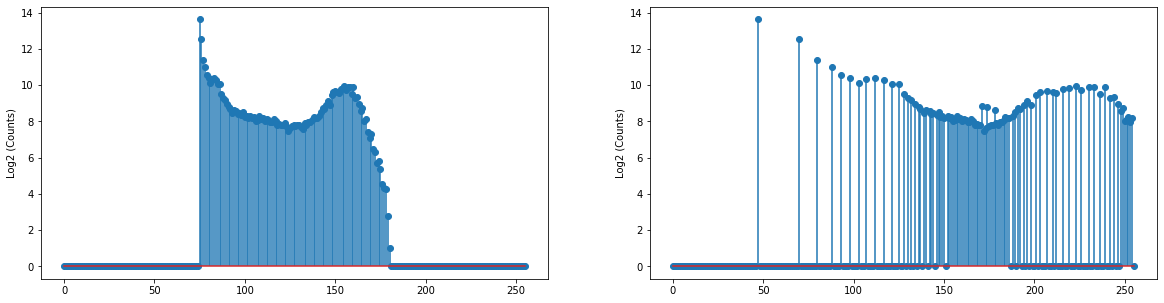

In [38]:
a = histEqualization(img4)

## 2. Observations with Histogram Equalisation

#### Contrast Stretching

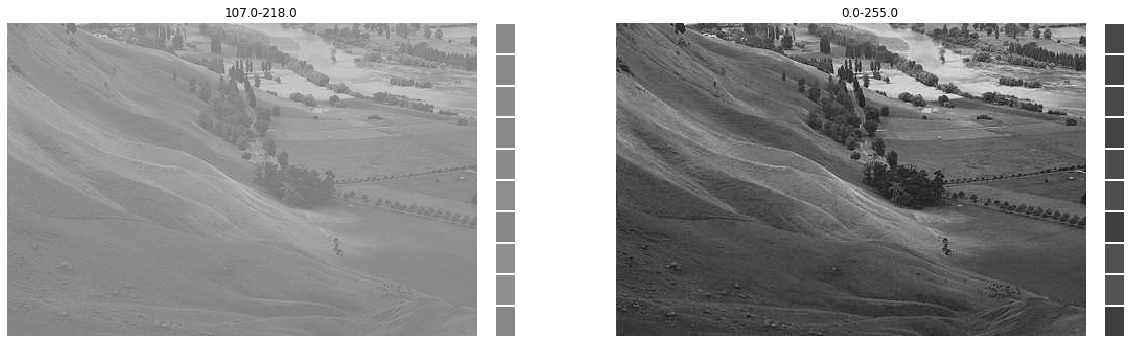

In [39]:
timg = linContrastStretching(mount, 0,255)

#### Histogram Equalisation

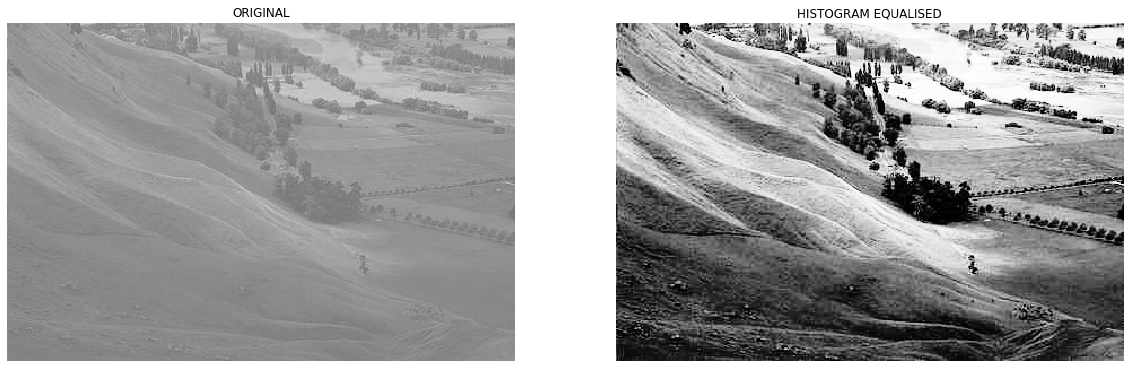

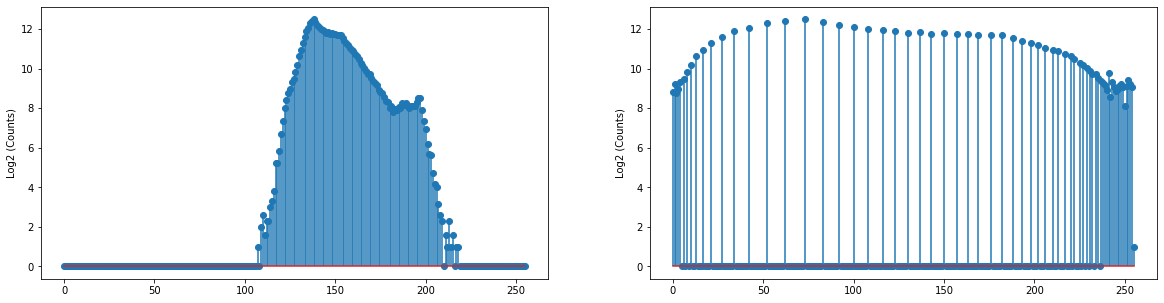

In [40]:
timg = histEqualization(mount)

---
As can be observed, histogram equalisation produces better results for the given image. This is because histogram equalisation will spread out those regions in the histogram, with higher pixel density, over a much bigger range. It will map the colors with low pixel density to a shorter range. This brings out more contrast than simple contrast stretching, which will just map the colors evenly, without consideration of what actual color frequencies are.  

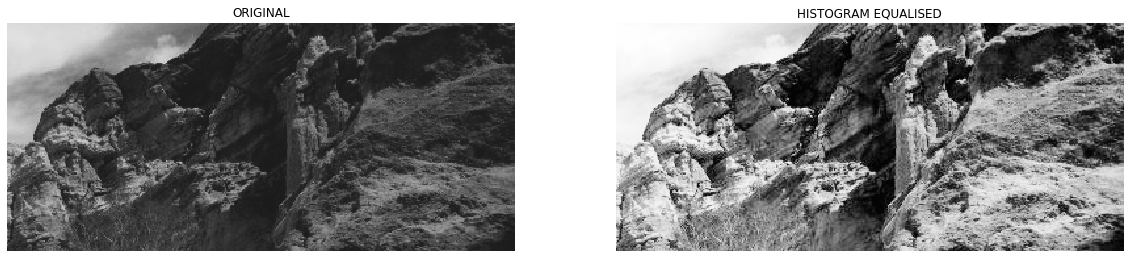

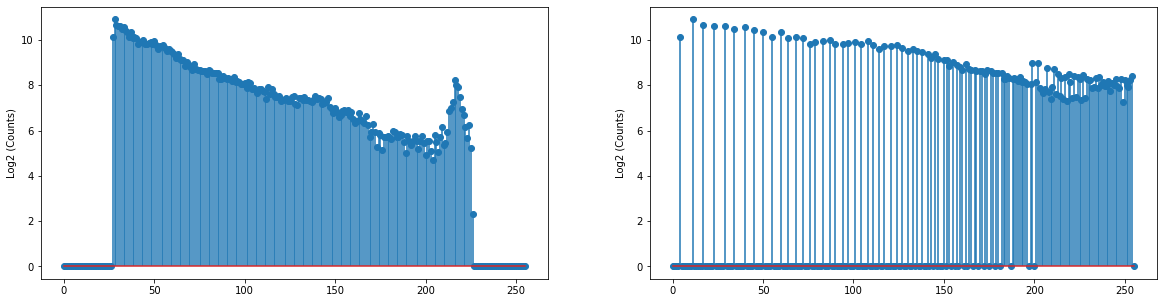

In [41]:
timg = histEqualization(img2)

---
Another observation is that the lightes color is always mapped to 255. This is due to the fact that histogram equalisation will try to provide equal weights to all colors, the final one hence being mapped to one.  
  
Also, it can be observed in this image, the lower grey values have been stretched over a bigger range than the higher white values, bringing out more details in the rock, as opposed to the sky, where we actually lose detail.

## 3. Histogram Matching

In [42]:
def histMatching(img, imgref, Plot=True):
    equalised_img = histEqualization(img, Plot=False)
    
    Tz = [0 for i in range(256)]
    e2 = histEqualization(imgref, Tr=Tz, Plot=False)
    Tz = np.array(Tz)
    
    timg = np.zeros(img.shape)
    
    for i in range(256):
        mask = np.array((equalised_img==i), dtype=np.float64)
        idx = np.argmax(Tz>=i)
        
        z = idx
        if not (Tz>=i).any():
            z = 255
        elif idx>0 and abs(Tz[idx-1]-i) < abs(Tz[idx]-i):
            z = idx-1
        
        if z>255: print(i,z)
        timg += mask*z
    
    if Plot==True:
        plot([img, imgref, timg], gray=True, vmap={'vmin':0, 'vmax':255}, titles=['ORIGINAL', 'REFFERNCE', 'HISTOGRAM MATCHED'])

        h1 = np.array([np.sum(np.array((img==i), dtype=np.float64)) for i in range(256)])
        h2 = np.array([np.sum(np.array((imgref==i), dtype=np.float64)) for i in range(256)])
        h3 = np.array([np.sum(np.array((timg==i), dtype=np.float64)) for i in range(256)])


        fig = plt.figure(figsize=(20,5))

        ax = fig.add_subplot(131)
        ax.stem(np.linspace(0,255,256), np.log2(1+h1), use_line_collection=True)
        ax.set_ylabel("Log2 (Counts)")

        ax2 = fig.add_subplot(132)
        ax2.stem(np.linspace(0,255,256), np.log2(1+h2), use_line_collection=True) 
        ax2.set_ylabel("Log2 (Counts)")

        ax3 = fig.add_subplot(133)
        ax3.stem(np.linspace(0,255,256), np.log2(1+h3), use_line_collection=True) 
        ax3.set_ylabel("Log2 (Counts)")
        
    return timg

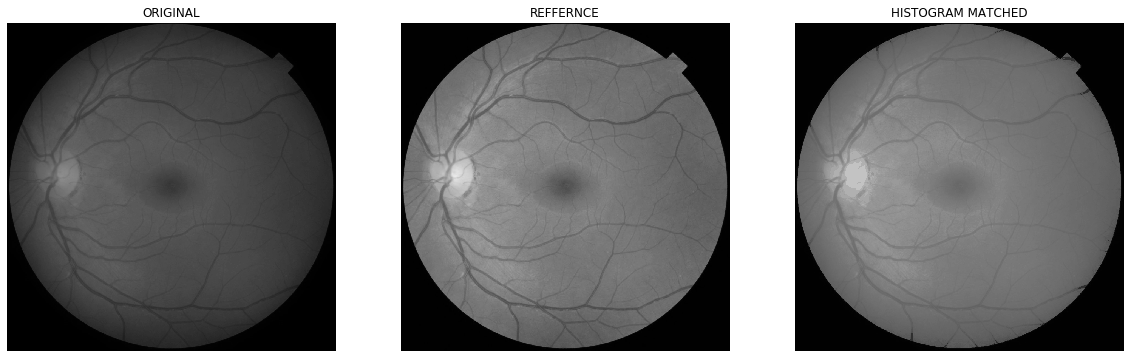

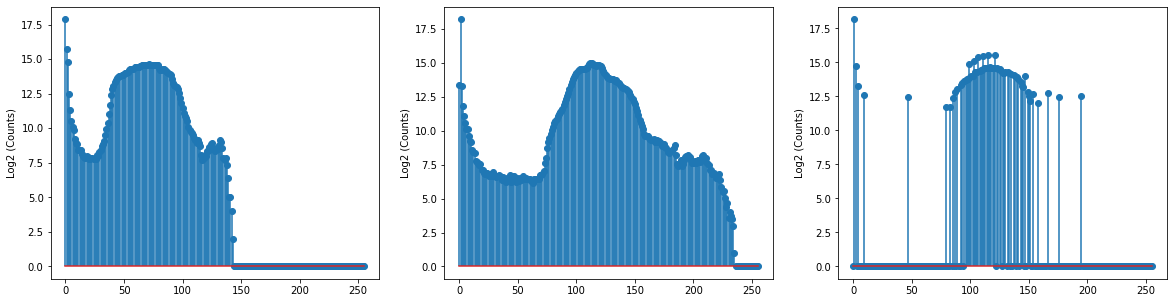

In [43]:
a = histMatching(eye, eyeref)

## 4. Recover Imgs

In [44]:
fimg = np.zeros((img.shape))
fimg[:img1.shape[0], :img1.shape[1]] = img1
fimg[:img1.shape[0], img1.shape[1]:] = img2
fimg[img1.shape[0]:, :img1.shape[1]] = img3
fimg[img1.shape[0]:, img1.shape[1]:] = img4

oimg = np.zeros((img.shape))

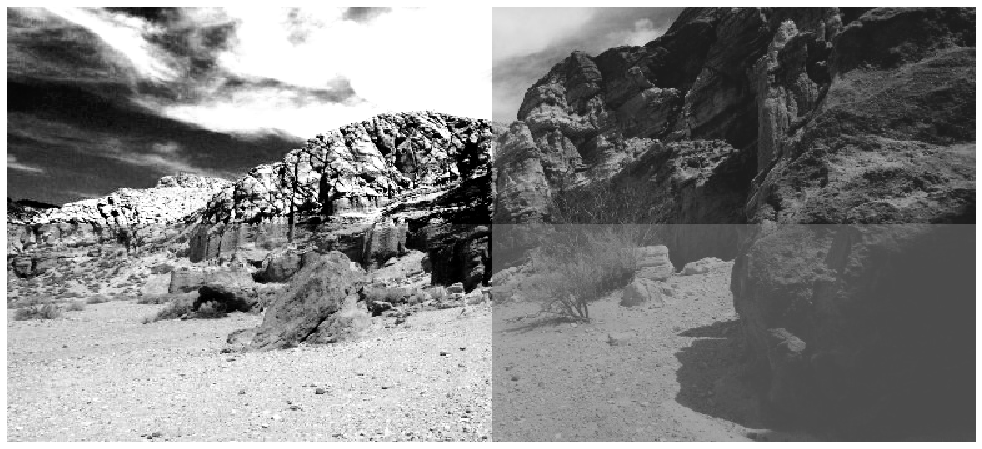

In [45]:
plot([fimg], gray=True)

In [46]:
oimg[:img1.shape[0], :img1.shape[1]] = histMatching(img1, img[:img1.shape[0], :img1.shape[1]], Plot=False)
oimg[:img1.shape[0], img1.shape[1]:] = histMatching(img2, img[:img1.shape[0], img1.shape[1]:], Plot=False)
oimg[img1.shape[0]:, :img1.shape[1]]=histMatching(img3, img[img1.shape[0]:, :img1.shape[1]], Plot=False)
oimg[img1.shape[0]:, img1.shape[1]:] = histMatching(img4, img[img1.shape[0]:, img1.shape[1]:], Plot=False)

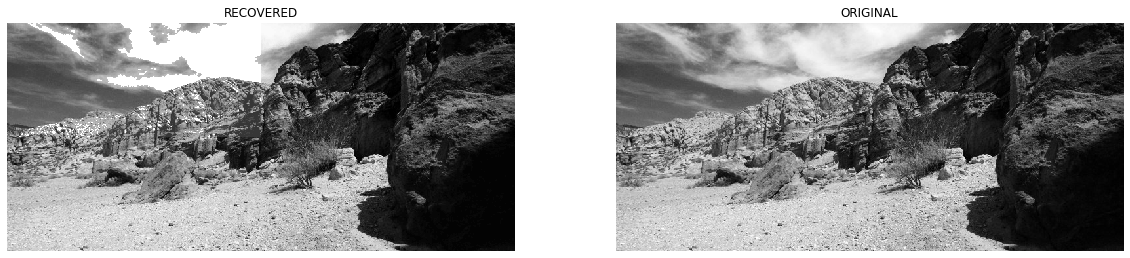

In [47]:
plot([oimg, img], gray=True, titles=['RECOVERED', 'ORIGINAL'], FigSize=(20,20))

---
<div width="100%" align="center"> <h1>Q7</h1></div>

---

## 1. HistEqualisation on HistEqualisation

In [48]:
img = read_img(root+'fg.jpg', gray=True)

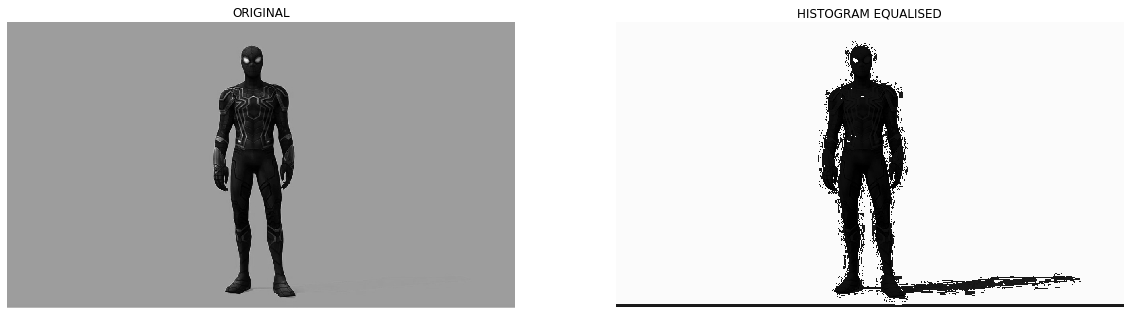

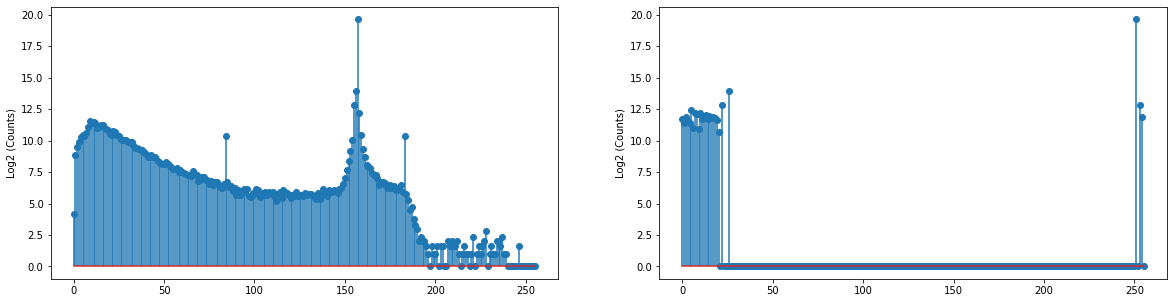

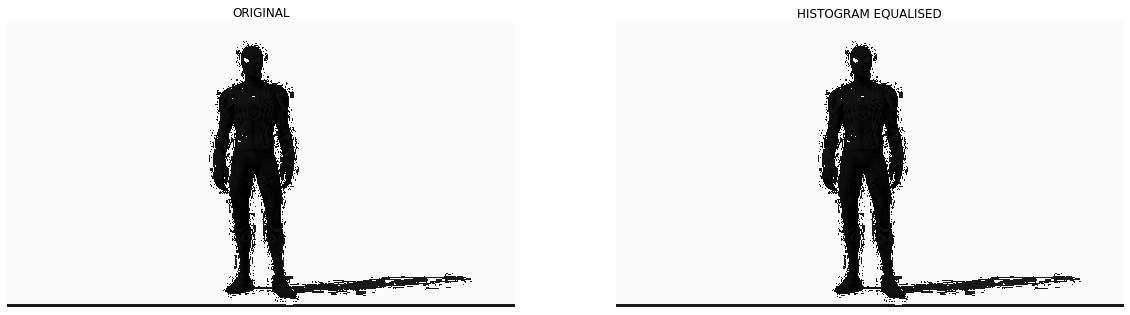

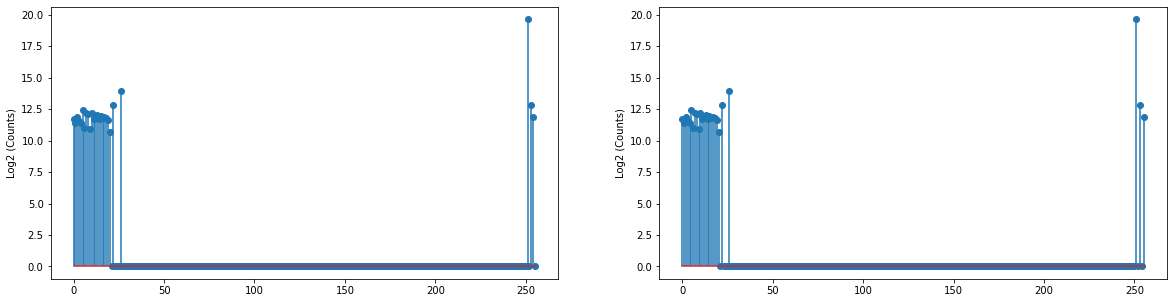

In [49]:
h1_img = histEqualization(img)
h2_img = histEqualization(h1_img)

As can be seen there is no change when we apply histogram equalisation again on an already histogram equalised image.

***PROOF BY INDUCTION*** 

\begin{align*}
&P(r_1 \leq x)*(L-1) = l\\
&P(r_2 \leq l)*(L-1) = s\\
\end{align*}
Since all the values of $r_1$ less than $x$ will have mapped to something less than or equal to $l$ (since T($r_1$) is monotonically incrreasing),  
therefore, 
\begin{align*}
P(r_1 \leq x) &= P(r_2 \leq l)\\
\Rightarrow l&=s
\end{align*}


## 2. Histogram Transformations

In [50]:
img = read_img(root + 'cameraman.png', gray=True)

dark = linContrastStretching(img, 0,100, Plot=False)
light = linContrastStretching(img, 155,255, Plot=False)

img2 = read_img(root+'../inputs/images.jpeg', gray=True)
img3 = read_img(root+'../inputs/i9.jpg', gray=True)


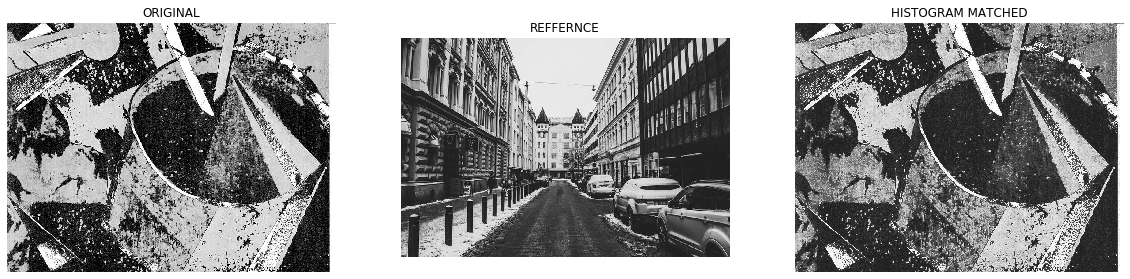

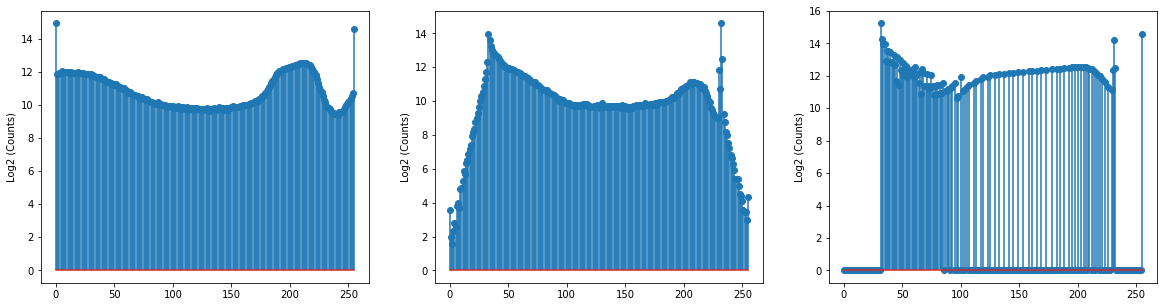

In [51]:
a = histMatching(img3, img2)

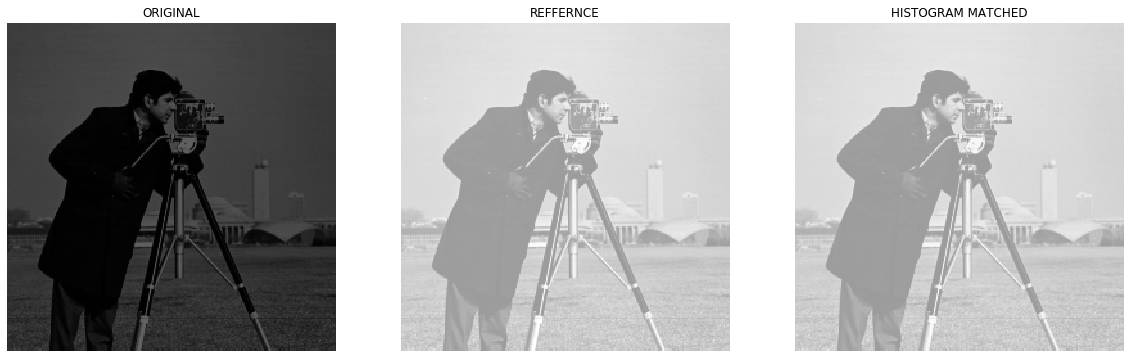

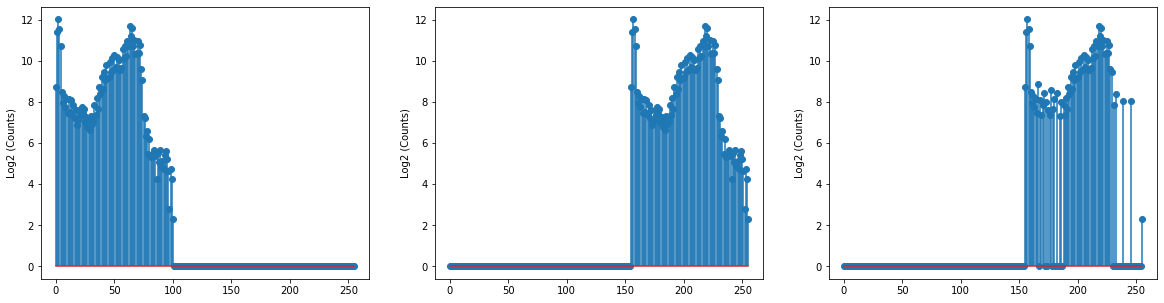

In [52]:
a = histMatching(dark, light)

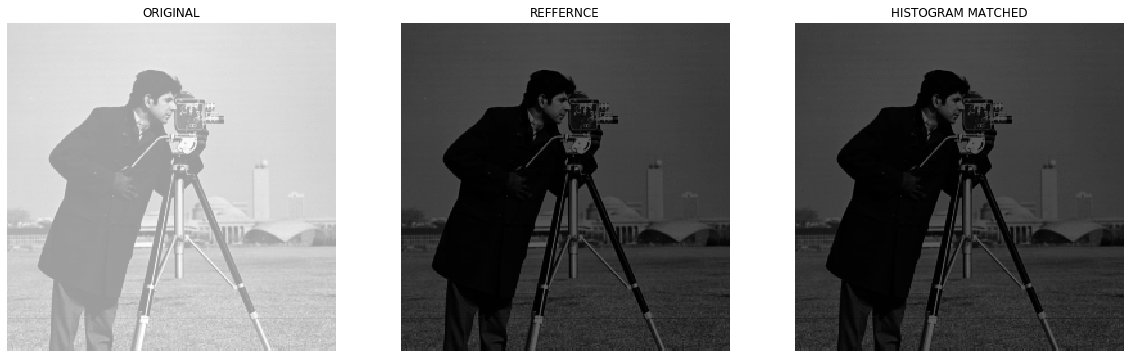

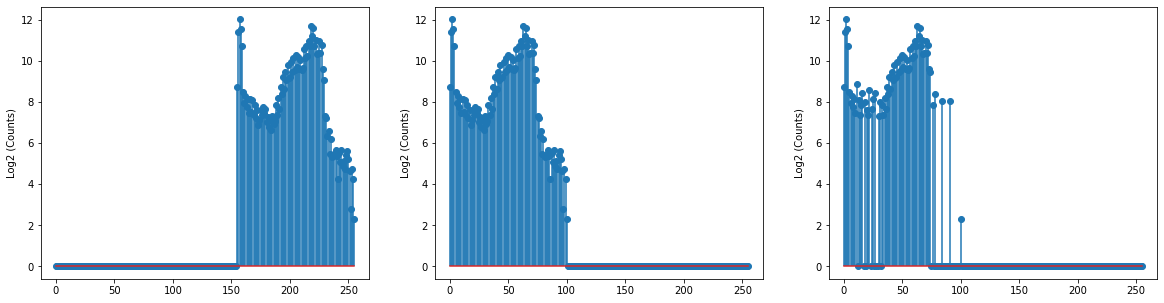

In [53]:
a = histMatching(light, dark)